# Intra-Class Variance

Pruebas para ver si puedo medir el grado de varianza / similitud intra-clase en un dataset de imágenes y usarlo para algo

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import torch
import torch.nn.functional as F
import pytorch_lightning as pl
from torch import nn
from torch.utils.data import Subset, ConcatDataset
import torchmetrics

from sklearn.model_selection import KFold
from sklearn.metrics import classification_report
from torchvision import datasets, transforms
from tqdm.autonotebook import tqdm

La distancia de Minkowski puede servirnos para dirimir el grado de similitud entre dos muestras (tensores). Por ejemplo:

In [43]:
data_transforms = transforms.Compose([
    transforms.ToTensor(),
])
image_dataset = datasets.ImageFolder('../data/UTKFace/train', data_transforms)
dl = torch.utils.data.DataLoader(image_dataset, batch_size=10, shuffle=True, num_workers=4)

distance: tensor([0.0003])


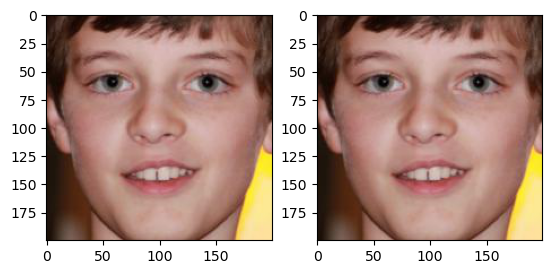

In [53]:
X,_ = next(iter(dl))
im1, im2 = X[4], X[4]
fig, ax = plt.subplots(1,2)
ax[0].imshow(im1.permute(1,2,0))
ax[1].imshow(im2.permute(1,2,0))
dist = nn.PairwiseDistance(p=2.0)(im1.flatten().unsqueeze(0),im2.flatten().unsqueeze(0))
print('distance:', dist)

La diferencia es mínima porque se trata de la misma imagen.

distance: tensor([101.0191])


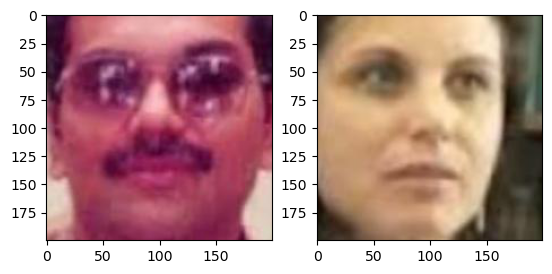

In [55]:
X,_ = next(iter(dl))
im1, im2 = X[0], X[4]
fig, ax = plt.subplots(1,2)
ax[0].imshow(im1.permute(1,2,0))
ax[1].imshow(im2.permute(1,2,0))
dist = nn.PairwiseDistance(p=2.0)(im1.flatten().unsqueeze(0),im2.flatten().unsqueeze(0))
print('distance:', dist)

Aquí la diferencia es más notable porque son imágenes distintas

In [14]:
class Minkowski_Variance:
    def __init__(self, path):
        self.path = path
        data_transforms = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ])

        image_dataset = datasets.ImageFolder(path, data_transforms)
        self.class_to_idx = image_dataset.class_to_idx
        self.idx_to_class = dict((v,k) for k,v in self.class_to_idx.items())
        print(self.class_to_idx, self.idx_to_class)

        class_0_idxs = torch.nonzero(torch.Tensor(image_dataset.targets)==0).flatten()
        class_1_idxs = torch.nonzero(torch.Tensor(image_dataset.targets)==1).flatten()

        c0_s, c1_s = len(class_0_idxs), len(class_1_idxs)
        b_deg = c0_s / c1_s
        print('Class 0:', len(class_0_idxs), '/ Class 1:', len(class_1_idxs), '/ BDeg: ', b_deg)

        class_0_subset = Subset(image_dataset, class_0_idxs)
        class_1_subset = Subset(image_dataset, class_1_idxs)

        class_0_dl = torch.utils.data.DataLoader(class_0_subset, batch_size=10, shuffle=True, num_workers=4)
        class_1_dl = torch.utils.data.DataLoader(class_1_subset, batch_size=10, shuffle=True, num_workers=4)
        
        print('Calculando distancias clase 0...', end='')
        self.class_0_distances = torch.Tensor([])
        for X, _ in class_0_dl:
            distancias = torch.cdist(X.reshape(X.shape[0], -1), X.reshape(X.shape[0], -1))
            sup_t = torch.triu(distancias, diagonal=1)
            sup_t = sup_t[sup_t != 0.]
            self.class_0_distances = torch.cat((self.class_0_distances, sup_t), dim=0)
        print('Done')
        
        print('Calculando distancias clase 1...', end='')
        self.class_1_distances = torch.Tensor([])
        for X, _ in class_1_dl:
            distancias = torch.cdist(X.reshape(X.shape[0], -1), X.reshape(X.shape[0], -1))
            sup_t = torch.triu(distancias, diagonal=1)
            sup_t = sup_t[sup_t != 0.]
            self.class_1_distances = torch.cat((self.class_1_distances, sup_t), dim=0)
        print('Done')

    def plot_histograms(self, width=1, num_bins=50, fig_size=(16, 6)):
        """ Muestra los histogramas de distancias de Minkowski de las clases """
        hist = torch.histogram(self.class_0_distances,
                               bins=torch.linspace(
                                   self.class_0_distances.min(),
                                   self.class_0_distances.max(),
                                   num_bins)
                              )
        _, axs = plt.subplots(1,2, figsize=fig_size)
        axs[0].bar(hist.bin_edges[1:], hist.hist.numpy(), align='edge', width=width, color=['forestgreen'])
        axs[0].set_title(f'Varianza intra-clase, Clase {self.idx_to_class[0]}')
        axs[0].set_xlabel('Distancia de Minkowski')
        axs[0].set_ylabel('Frecuencia')

        hist = torch.histogram(self.class_1_distances,
                               bins=torch.linspace(
                                   self.class_1_distances.min(),
                                   self.class_1_distances.max(),
                                   num_bins)
                              )
        axs[1].set_title(f'Varianza intra-clase, Clase {self.idx_to_class[1]}')
        axs[1].bar(hist.bin_edges[1:], hist.hist.numpy(), align='edge', width=width, color=['blue'])
        axs[1].set_xlabel('Distancia de Minkowski')
        axs[1].set_ylabel('Frecuencia')
        plt.show()
        
    def log_statistics(self):
        """ devuelve medidas estadisticas basicas de un tensor 1-D """
        print(f'Estadisticas dataset: {self.path}')
        print('---------------------------------------------------------')
        for c, D in enumerate([self.class_0_distances, self.class_1_distances]):
            mean = torch.mean(D)
            median = torch.median(D)
            std = torch.std(D)
            var = torch.var(D)
            print(f'== Clase {self.idx_to_class[c]}')
            print(f'\tMedia:\t\t\t\t{mean}')
            print(f'\tMediana:\t\t\t{median}')    
            print(f'\tDesviacion estándar:\t\t{std}')    
            print(f'\tVarianza:\t\t\t{var}')    

## <span style="color:blue">PlantVillage</span>

In [15]:
mv_pv = Minkowski_Variance(path='../data/PlantVillage/train')

{'tomato_healthy': 0, 'tomato_infected': 1} {0: 'tomato_healthy', 1: 'tomato_infected'}
Class 0: 1264 / Class 1: 308 / BDeg:  4.103896103896104
Calculando distancias clase 0...Done
Calculando distancias clase 1...Done


In [16]:
mv_pv.log_statistics()

Estadisticas dataset: ../data/PlantVillage/train
---------------------------------------------------------
== Clase tomato_healthy
	Media:				431.1598815917969
	Mediana:			443.5098571777344
	Desviacion estándar:		97.12478637695312
	Varianza:			9433.224609375
== Clase tomato_infected
	Media:				393.4624328613281
	Mediana:			390.9932861328125
	Desviacion estándar:		51.227108001708984
	Varianza:			2624.216552734375


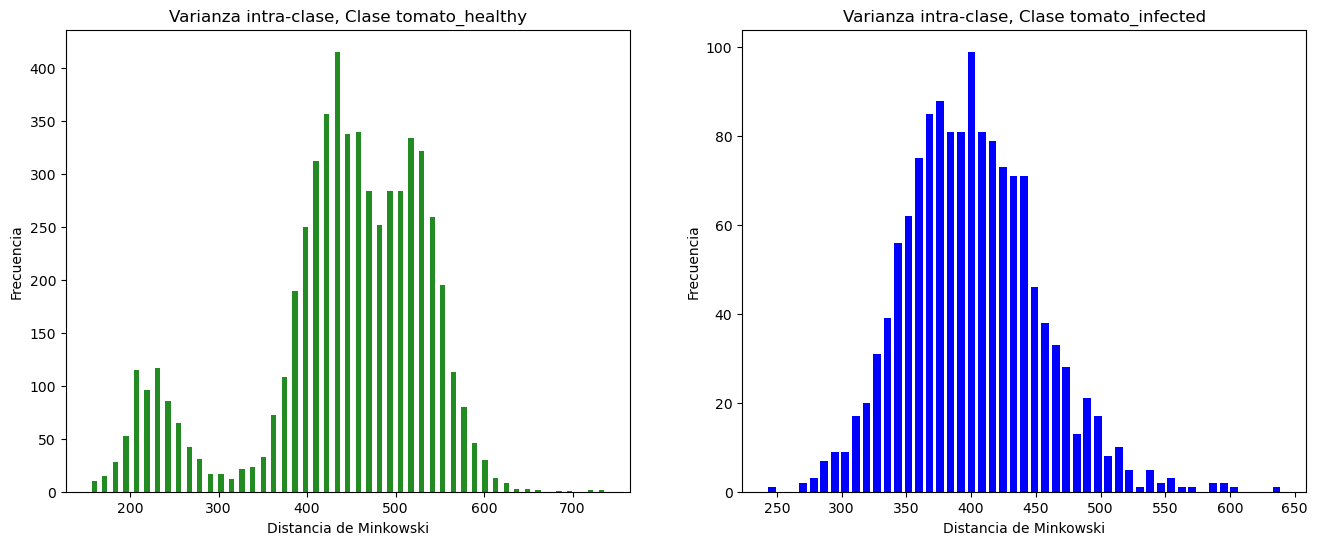

In [18]:
mv_pv.plot_histograms(width=6, num_bins=50, fig_size=(16, 6))

## <span style="color:blue">UTKFace</span>

In [19]:
mv_utk = Minkowski_Variance(path='../data/UTKFace/train')

{'female': 0, 'male': 1} {0: 'female', 1: 'male'}
Class 0: 11317 / Class 1: 12391 / BDeg:  0.913324186909854
Calculando distancias clase 0...Done
Calculando distancias clase 1...Done


In [20]:
mv_utk.log_statistics()

Estadisticas dataset: ../data/UTKFace/train
---------------------------------------------------------
== Clase female
	Media:				468.6468811035156
	Mediana:			458.174560546875
	Desviacion estándar:		106.98777770996094
	Varianza:			11446.384765625
== Clase male
	Media:				466.12567138671875
	Mediana:			455.81719970703125
	Desviacion estándar:		106.38594055175781
	Varianza:			11317.96875


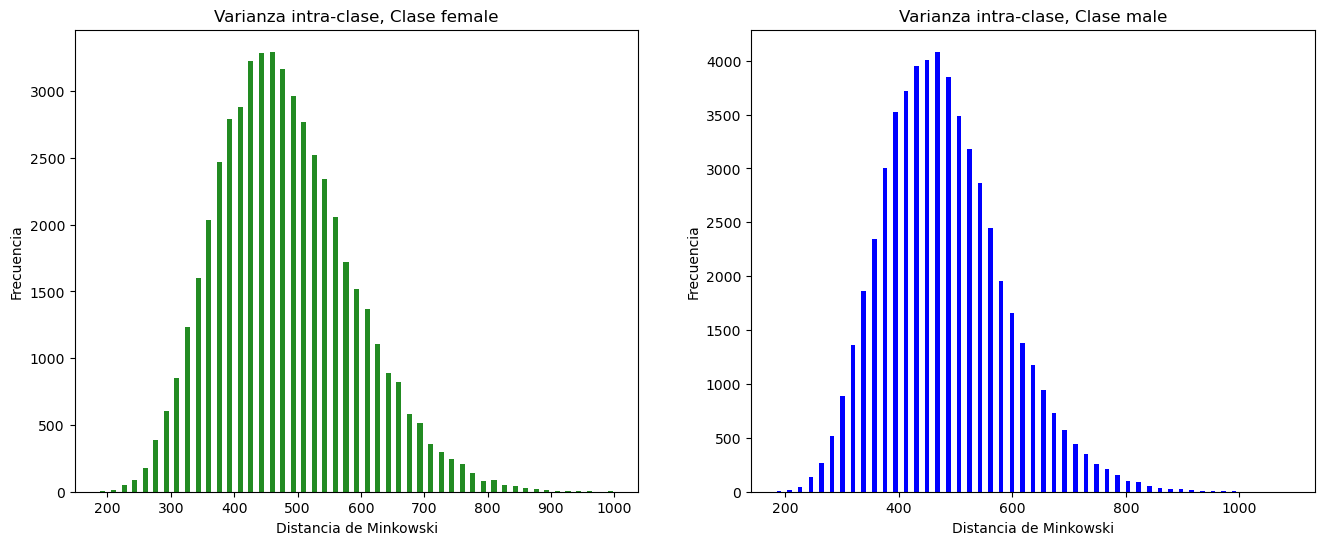

In [21]:
mv_utk.plot_histograms(width=8)

## <span style="color:blue">Fair Face</span>

In [62]:
mv_ff = Minkowski_Variance(path='../data/FairFace/train')

{'female': 0, 'male': 1} {0: 'female', 1: 'male'}
Class 0: 43405 / Class 1: 48695 / BDeg:  0.8913646164903994
Calculando distancias clase 0...Done
Calculando distancias clase 1...Done


In [63]:
mv_ff.log_statistics()

Estadisticas dataset: ../data/FairFace/train
---------------------------------------------------------
== Clase female
	Media:				537.8436889648438
	Mediana:			525.1722412109375
	Desviacion estándar:		130.74505615234375
	Varianza:			17094.26953125
== Clase male
	Media:				533.6594848632812
	Mediana:			520.4456176757812
	Desviacion estándar:		130.75839233398438
	Varianza:			17097.755859375


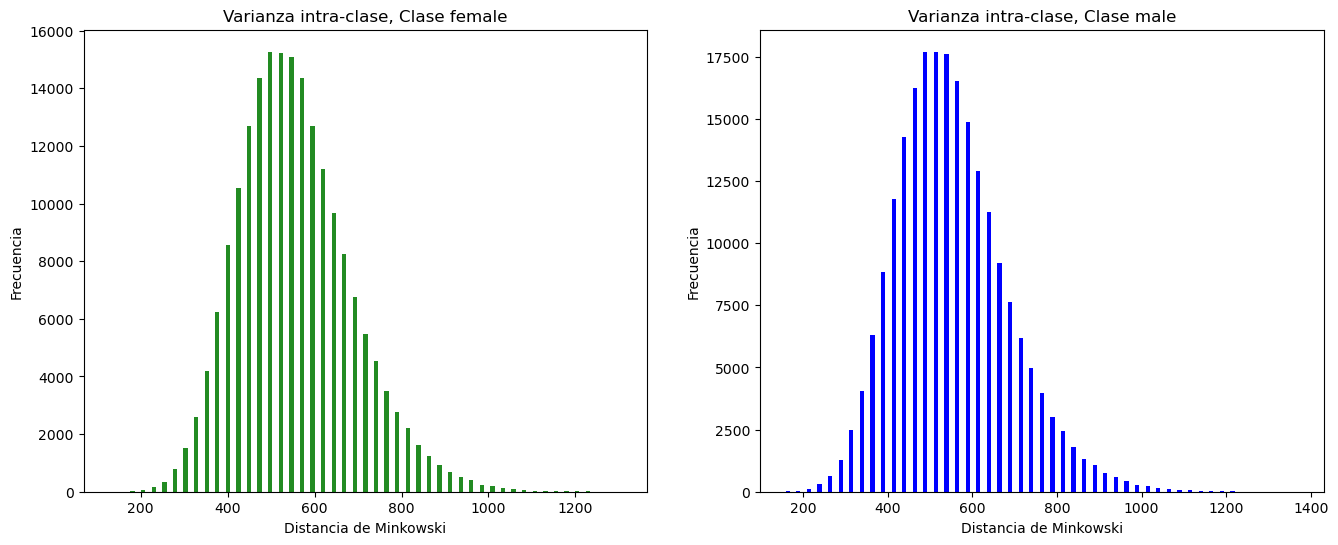

In [65]:
mv_ff.plot_histograms(width=10)

## <span style="color:blue">MNIST (sólo 0 y 1)</span>

In [56]:
mv_mnist = Minkowski_Variance(path='../data/MNIST')

{'0': 0, '1': 1, '2': 2, '3': 3, '4': 4, '5': 5, '6': 6, '7': 7, '8': 8, '9': 9} {0: '0', 1: '1', 2: '2', 3: '3', 4: '4', 5: '5', 6: '6', 7: '7', 8: '8', 9: '9'}
Class 0: 6796 / Class 1: 7740 / BDeg:  0.8780361757105943
Calculando distancias clase 0...Done
Calculando distancias clase 1...Done


In [57]:
mv_mnist.log_statistics()

Estadisticas dataset: ../data/MNIST
---------------------------------------------------------
== Clase 0
	Media:				74.09000396728516
	Mediana:			75.23258972167969
	Desviacion estándar:		11.829806327819824
	Varianza:			139.94432067871094
== Clase 1
	Media:				48.67056655883789
	Mediana:			49.32073974609375
	Desviacion estándar:		13.54456901550293
	Varianza:			183.45533752441406


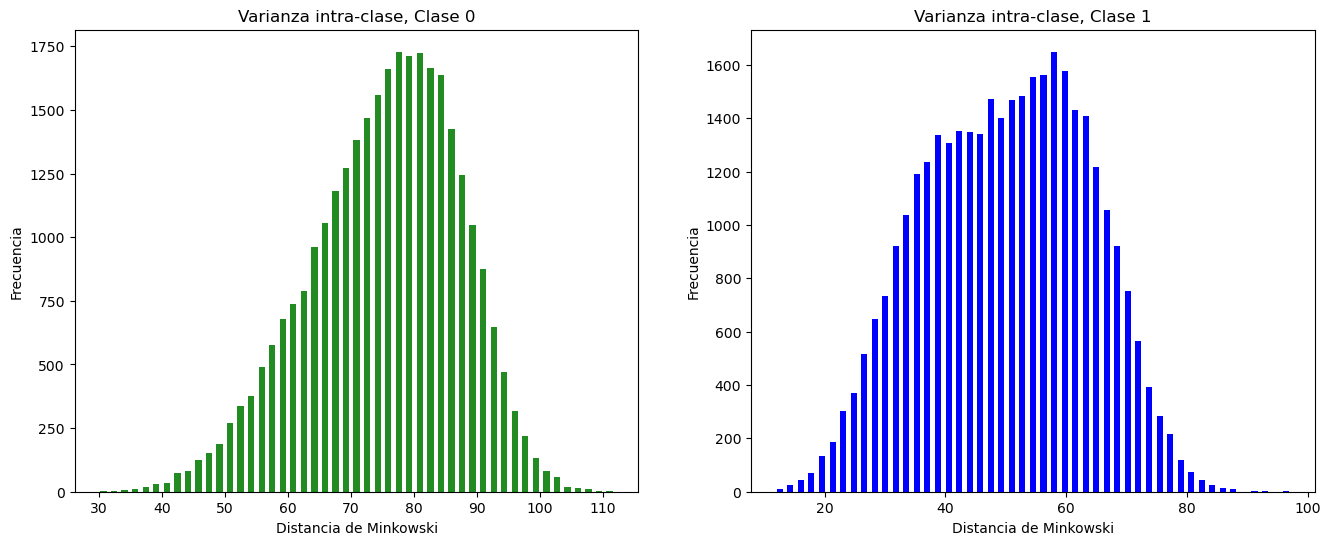

In [60]:
mv_mnist.plot_histograms(width=1)